# Transformer test

__Obejctive:__ test a transformer model on the root inference problem.

In [1]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import torch
from torch import nn

import sys

sys.path.append('../modules/')

%cd ~/SRLM/Emanuele_git/tree-language/modules

from training import train_model
from plotting import plot_training_history
from models import TransformerClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Running on device:', device)

%load_ext autoreload
%autoreload 2

/home/Garnier/SRLM/Emanuele_git/tree-language/modules
Running on device: cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
from matplotlib import pyplot as plt
from numba import njit

In [4]:
# Naive Bayes benchmark
def get_NB_accuracy(x0s,xis_int,train_frac):
    xi_train, xi_test, x0_train, x0_test = train_test_split(xis_int.T, x0s, test_size=1-train_frac, random_state=0)
    gnb = GaussianNB()
    gnb.fit(xi_train, x0_train)
    y_pred = gnb.predict(xi_test)
    return np.sum((x0_test == y_pred))/len(x0_test) 

## Exact Naive Bayes

In [5]:
@njit
def compute_Mprod(M,l):
    q = M.shape[0]
    M_L = np.sum(M,axis=2).T
    M_R = np.sum(M,axis=1).T
    M_prods = np.zeros((q,q,2**l))
    M_prods[:,:,0] = np.eye(q)
    M_prods_prev = np.zeros((q,q,2**l))
    M_prods_prev[:,:,0] = np.eye(q)
    for k in range(1,l+1):
        for i in range(0,2**k,2):
            M_prods[:,:,i] = M_L@M_prods_prev[:,:,i//2]
        for i in range(1,2**k,2):
            M_prods[:,:,i] = M_R@M_prods_prev[:,:,i//2]
        M_prods_prev[:,:,:2**k] = M_prods[:,:,:2**k]
    return M_prods

@njit
def get_NB_class(xis,M_prods):
    q = M_prods.shape[0]
    N = M_prods.shape[2] # Number of leaves
    prod = np.ones(q)
    for i in range(N):
        prod = prod*M_prods[xis[i],:,i]
    return np.argmax(prod)

In [6]:
def get_NB_accuracy(x0s,xis,M,l):
    N_data = xis.shape[1]
    x0 = np.empty(N_data)
    M_prods = compute_Mprod(M,l)
    for i in range(N_data):
        x0[i] = get_NB_class(xis[:,i],M_prods)
    return np.sum((x0s == x0))/len(x0)

## Load data

In [11]:
# Data that will be used
q = 4
l = 8
sigma = 1.0
epsilon = 0.0
seed = 1

N_learn = int(2**14)

#[q,l,sigma,epsilon,x0s,xis,M_s] = np.load('../data/labeled_data_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)
%cd ~/SRLM
[q,l,sigma,epsilon,x0s,xis,M_s] = np.load('./sim_data/labeled_data_fixed_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)
print(x0s.shape)
indices = np.arange(x0s.shape[0])
np.random.shuffle(indices)
x0 = x0s[indices,seed]
xi = xis[:,indices,seed]
phi_NB = get_NB_accuracy(x0[N_learn:],xi[:,N_learn:],M_s[:,:,:,seed],l)
print('Exact Naives Bayes accuracy: {:.2f}, tested on {} trees.'.format(phi_NB,len(x0[N_learn:])))

/home/Garnier/SRLM
(50000, 32)
Exact Naives Bayes accuracy: 0.32, tested on 33616 trees.


In [12]:
[q,l,sigma,epsilon,entropy,BP_accuracies,BP_avg_marginals,NB_accuracies,NB_census_accuracies,N_trials,train_frac,seeds,M_s] = np.load('./sim_data/RootInference_BP_NB_wCensus_{}_{}_{:.2f}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)

In [13]:
print('Sklearn Naives Bayes accuracy: {:.2f}, trained on {} and tested on {} trees.'.format(NB_accuracies[seed],int(N_trials*train_frac),int(N_trials*(1-train_frac))))
print('Sklearn Census Naives Bayes accuracy: {:.2f}, trained on {} and tested on {} trees.'.format(NB_census_accuracies[seed],int(N_trials*train_frac),int(N_trials*(1-train_frac))))

Sklearn Naives Bayes accuracy: 0.27, trained on 10000 and tested on 10000 trees.
Sklearn Census Naives Bayes accuracy: 0.25, trained on 10000 and tested on 10000 trees.


## Data preprocessing

In [14]:
# convert data to be used in pytorch
N_test = 10000
x_train = torch.from_numpy(xi[:,:N_learn].T).to(device=device).int()
x_test = torch.from_numpy(xi[:,N_learn:N_test+N_learn].T).to(device=device).int()

# Target labels WITHOUT one-hot encoding.
#y_train = torch.from_numpy(x0[:N_learn]).to(device=device).to(dtype=torch.int64)
#y_test = torch.from_numpy(x0[N_learn:]).to(device=device).to(dtype=torch.int64)

# Target labels WITH one-hot encoding.
y_train = nn.functional.one_hot(torch.from_numpy(x0[:N_learn]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
y_test = nn.functional.one_hot(torch.from_numpy(x0[N_learn:N_test+N_learn]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)

## Model training

In [18]:
model = TransformerClassifier(
    seq_len=int(2**l),
    embedding_size=128,
    n_tranformer_layers=3,
    n_heads=1,
    vocab_size=q,
    embedding_agg='flatten',
    positional_encoding=True,
    decoder_hidden_sizes=[]
).to(device=device)


In [19]:
# Number of epochs
num_epochs = 40

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

_, training_history = train_model(
    model=model,
    training_data=(x_train, y_train),
    test_data=(x_test, y_test),
    n_epochs=num_epochs,
    loss_fn=loss_fn,
    learning_rate=1e-3,
    batch_size=32,
    early_stopper=None
)

2024-04-25 10:45:14,246 - train_model - INFO - Training model
100%|██████████| 40/40 [06:10<00:00,  9.26s/it, training_accuracy=tensor(0.3763), training_loss=tensor(1.3253), val_accuracy=tensor(0.2833, device='cuda:0'), val_loss=tensor(1.4134, device='cuda:0')]
2024-04-25 10:51:24,554 - train_model - INFO - Last epoch: 40


f
NB 0.3161292241789624
Random 0.25


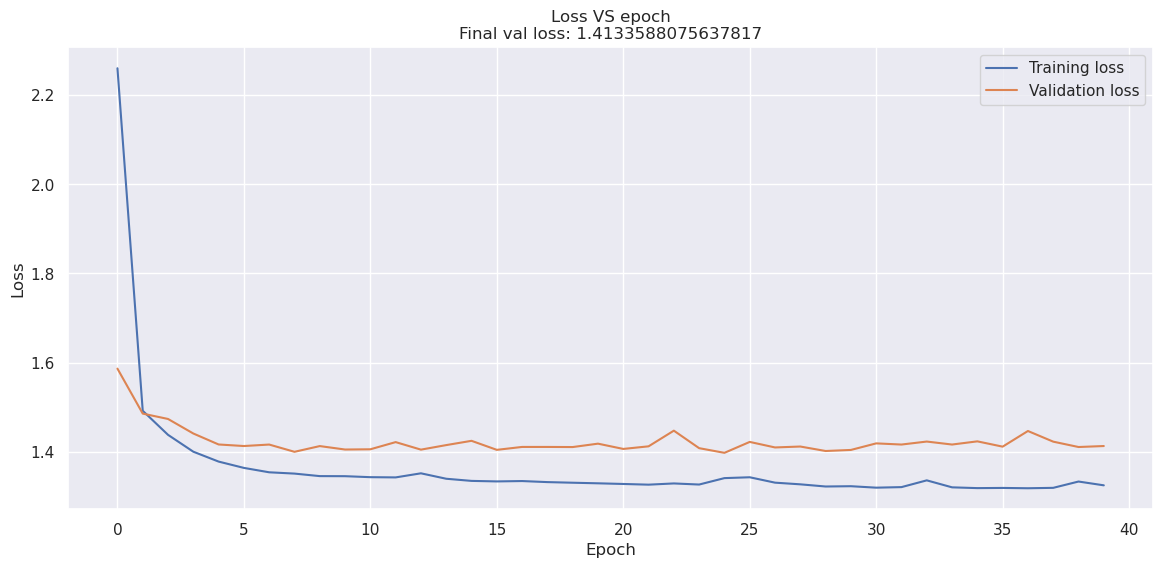

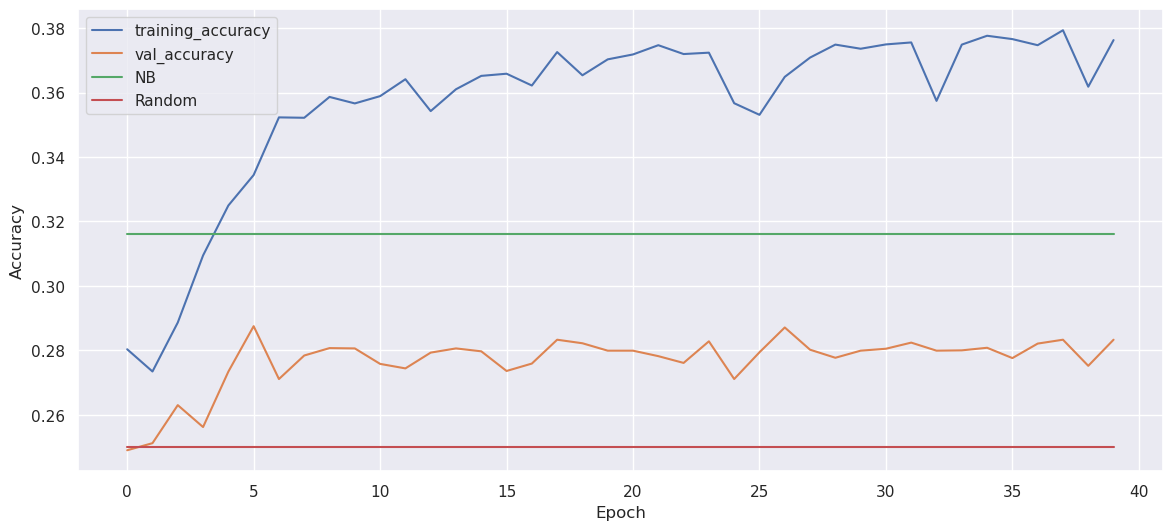

In [20]:
plot_training_history(
    training_history,
    baseline_accuracy={
        'NB': phi_NB,
        #'Census': NB_census_accuracies[seed]
        'Random': 1/q
    }
)

### Effect of the number of samples

In [14]:
# Data that will be used
q = 4
l = 8
sigma = 1.0
epsilon = 0.0
seed = 15

N_learn = 4096

#[q,l,sigma,epsilon,x0s,xis,M_s] = np.load('../data/labeled_data_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)
%cd ~/SRLM
[q,l,sigma,epsilon,x0s,xis,M_s] = np.load('./sim_data/labeled_data_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)
print(x0s.shape)
#x0 = x0s[:,seed]
#xi = xis[:,:,seed]
indices = np.arange(x0s.shape[0])
np.random.shuffle(indices)
x0 = x0s[indices,seed]
xi = xis[:,indices,seed]
phi_NB = get_NB_accuracy(x0[N_learn:],xi[:,N_learn:],M_s[:,:,:,seed],l)
print('Exact Naives Bayes accuracy: {:.2f}, tested on {} trees.'.format(phi_NB,len(x0[N_learn:])))

/home/Garnier/SRLM
(50000, 32)
Exact Naives Bayes accuracy: 0.30, tested on 45904 trees.


In [15]:
[q,l,sigma,epsilon,entropy,BP_accuracies,BP_avg_marginals,NB_accuracies,NB_census_accuracies,N_trials,train_frac,seeds,M_s] = np.load('./sim_data/RootInference_BP_NB_wCensus_{}_{}_{:.2f}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)

In [16]:
P = 2**np.arange(8,14)
N_test = 10000


y_test = nn.functional.one_hot(torch.from_numpy(x0[-N_test:]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
x_test = torch.from_numpy(xi[:,-N_test:].T).to(device=device).int()

In [17]:
print(P)

[ 256  512 1024 2048 4096 8192]


In [18]:
# Number of epochs
num_epochs = 100

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

x_train = torch.from_numpy(xi[:,:P[-1]].T).to(device=device).int()
y_train = nn.functional.one_hot(torch.from_numpy(x0[:P[-1]]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)

model = TransformerClassifier(
        seq_len=int(2**l),
        embedding_size=128,
        n_tranformer_layers=1,
        n_heads=1,
        vocab_size=q,
        embedding_agg='flatten',
        positional_encoding=False,
        decoder_hidden_sizes=[]
    ).to(device=device)

_, training_history = train_model(
    model=model,
    training_data=(x_train, y_train),
    test_data=(x_test, y_test),
    n_epochs=num_epochs,
    loss_fn=loss_fn,
    learning_rate=1e-4,
    batch_size=32,
    early_stopper=None
)

2024-04-23 12:28:46,910 - train_model - INFO - Training model
100%|██████████| 100/100 [03:14<00:00,  1.95s/it, training_accuracy=tensor(0.5969), training_loss=tensor(0.9915), val_accuracy=tensor(0.2859, device='cuda:0'), val_loss=tensor(1.8941, device='cuda:0')]
2024-04-23 12:32:01,886 - train_model - INFO - Last epoch: 100


f
NB 0.29873213663297316
Random 0.25


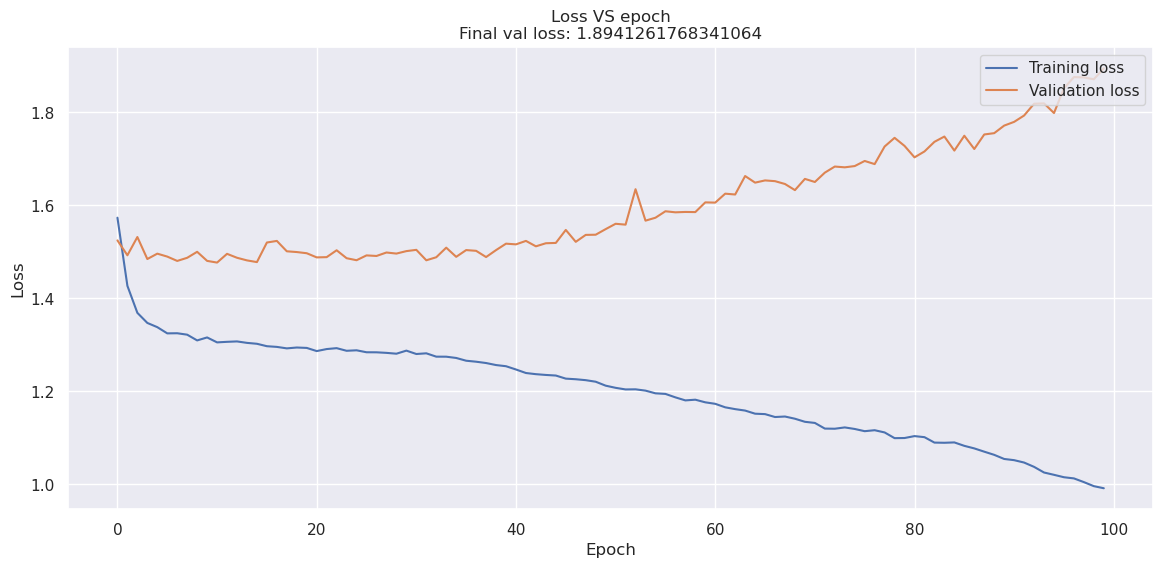

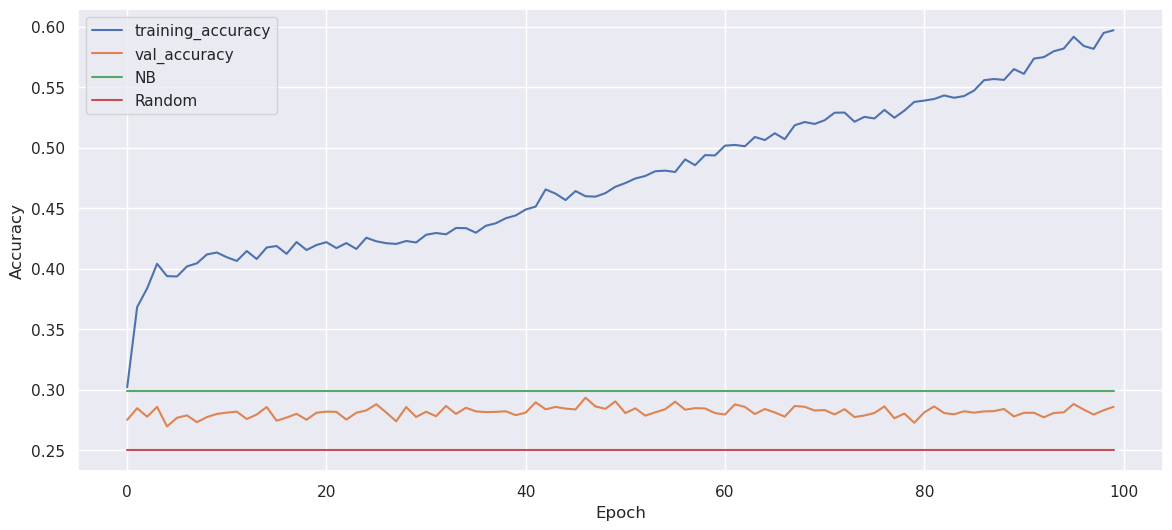

In [19]:
plot_training_history(
    training_history,
    baseline_accuracy={
        'NB': phi_NB,
        #'Census': NB_census_accuracies[seed]
        'Random': 1/q
    }
)

In [20]:
test_accuracies = np.empty(len(P))
num_epochs = 100

for i in range(len(P)):
    x_train = torch.from_numpy(xi[:,:P[i]].T).to(device=device).int()
    y_train = nn.functional.one_hot(torch.from_numpy(x0[:P[i]]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
    model = TransformerClassifier(
        seq_len=int(2**l),
        embedding_size=128,
        n_tranformer_layers=1,
        n_heads=1,
        vocab_size=q,
        embedding_agg='flatten',
        positional_encoding=False
    ).to(device=device)
    _, training_history = train_model(
        model=model,
        training_data=(x_train, y_train),
        test_data=(x_test, y_test),
        n_epochs=num_epochs,
        loss_fn=loss_fn,
        learning_rate=1e-4,
        batch_size=32,
        early_stopper=None
    )
    test_accuracies[i] = np.max(training_history['val_accuracy'])

2024-04-23 12:32:02,384 - train_model - INFO - Training model
100%|██████████| 100/100 [01:08<00:00,  1.46it/s, training_accuracy=tensor(1.), training_loss=tensor(0.0014), val_accuracy=tensor(0.2546, device='cuda:0'), val_loss=tensor(3.0691, device='cuda:0')]  
2024-04-23 12:33:10,716 - train_model - INFO - Last epoch: 100
2024-04-23 12:33:10,724 - train_model - INFO - Training model
100%|██████████| 100/100 [01:12<00:00,  1.38it/s, training_accuracy=tensor(1.), training_loss=tensor(0.0019), val_accuracy=tensor(0.2541, device='cuda:0'), val_loss=tensor(4.4757, device='cuda:0')]  
2024-04-23 12:34:23,212 - train_model - INFO - Last epoch: 100
2024-04-23 12:34:23,220 - train_model - INFO - Training model
100%|██████████| 100/100 [01:20<00:00,  1.24it/s, training_accuracy=tensor(1.), training_loss=tensor(0.0049), val_accuracy=tensor(0.2566, device='cuda:0'), val_loss=tensor(7.5151, device='cuda:0')]   
2024-04-23 12:35:43,864 - train_model - INFO - Last epoch: 100
2024-04-23 12:35:43,873 

In [21]:
test_accuracies_wPE = np.empty(len(P))
num_epochs = 20

for i in range(len(P)):
    x_train = torch.from_numpy(xi[:,:P[i]].T).to(device=device).int()
    y_train = nn.functional.one_hot(torch.from_numpy(x0[:P[i]]).to(dtype=torch.int64), num_classes=q).to(dtype=torch.float32).to(device=device)
    model = TransformerClassifier(
        seq_len=int(2**l),
        embedding_size=128,
        n_tranformer_layers=1,
        n_heads=1,
        vocab_size=q,
        embedding_agg='flatten',
        positional_encoding=True
    ).to(device=device)
    _, training_history = train_model(
        model=model,
        training_data=(x_train, y_train),
        test_data=(x_test, y_test),
        n_epochs=num_epochs,
        loss_fn=loss_fn,
        learning_rate=1e-4,
        batch_size=32,
        early_stopper=None
    )
    test_accuracies_wPE[i] = np.max(training_history['val_accuracy'])

2024-04-23 12:42:45,155 - train_model - INFO - Training model
100%|██████████| 20/20 [00:13<00:00,  1.45it/s, training_accuracy=tensor(1.), training_loss=tensor(0.0303), val_accuracy=tensor(0.2556, device='cuda:0'), val_loss=tensor(2.2212, device='cuda:0')]   
2024-04-23 12:42:58,977 - train_model - INFO - Last epoch: 20
2024-04-23 12:42:58,990 - train_model - INFO - Training model
100%|██████████| 20/20 [00:14<00:00,  1.36it/s, training_accuracy=tensor(1.), training_loss=tensor(0.0556), val_accuracy=tensor(0.2544, device='cuda:0'), val_loss=tensor(2.7430, device='cuda:0')]   
2024-04-23 12:43:13,662 - train_model - INFO - Last epoch: 20
2024-04-23 12:43:13,669 - train_model - INFO - Training model
100%|██████████| 20/20 [00:16<00:00,  1.22it/s, training_accuracy=tensor(0.9980), training_loss=tensor(0.1440), val_accuracy=tensor(0.2581, device='cuda:0'), val_loss=tensor(3.5904, device='cuda:0')]
2024-04-23 12:43:30,016 - train_model - INFO - Last epoch: 20
2024-04-23 12:43:30,025 - trai

f
NB 0.29873213663297316
Random 0.25


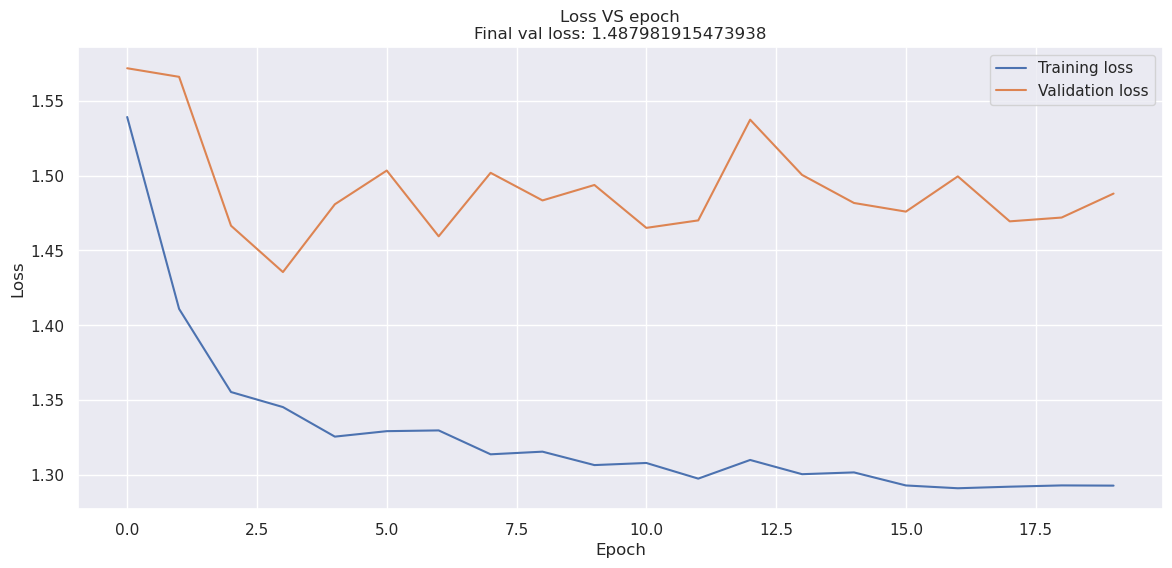

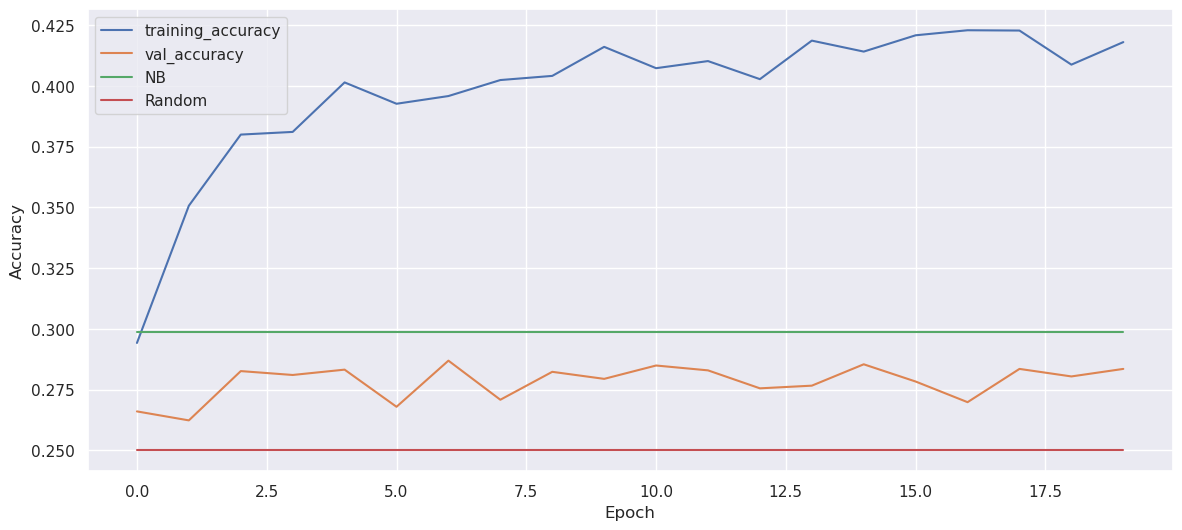

In [22]:
plot_training_history(
    training_history,
    baseline_accuracy={
        'NB': phi_NB,
        #'Census': NB_census_accuracies[seed]
        'Random': 1/q
    }
)

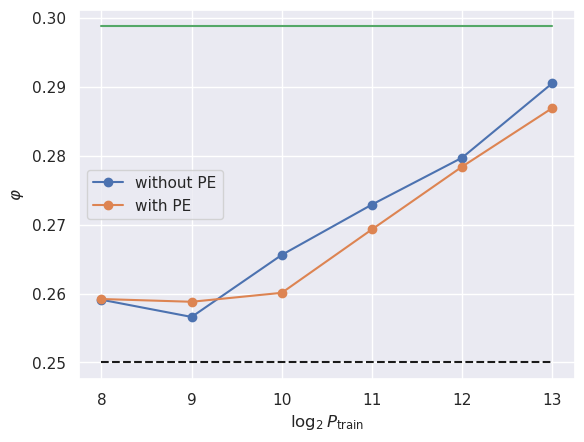

In [23]:
plt.plot(np.log2(P),test_accuracies,marker='o',label='without PE')
plt.plot(np.log2(P),test_accuracies_wPE,marker='o',label='with PE')
plt.plot(np.log2(P),phi_NB*np.ones(len(P)))
plt.plot(np.log2(P),1/q*np.ones(len(P)),color='k',ls='--')
plt.xlabel(r'$\log_2 P_{\mathrm{train}}$')
plt.ylabel(r'$\varphi$')
plt.legend()

plt.show()